This notebook was created by Donna Faith Go.

In [1]:
# import sys
# !{sys.executable} -m pip install arch

In [2]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd 
import pickle
import numpy as np
import seaborn as sns
from typing import Tuple

# data gathering
import yfinance as yf

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# GARCH model
from arch import arch_model

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# GARCH on the PSEi

This notebook aims to do volatility clustering on the Philippine Stock Exchange Composite Index (PSEi) through the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model.

## Data Gathering

In [3]:
# getting closing prices for the 30 stocks with batching
start_date = '2013-01-01'# '2019-01-01'
end_date = '2026-01-01' #'2025-08-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     ['PSEI.PS'], 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('psei closing prices.pkl')

In [4]:
filepath = r'psei closing prices.pkl'
with open(filepath, 'rb') as f:
    pse_data = pickle.load(f)

# pse_data = pse_data.loc[pd.Timestamp('2025-01-01'):]
print(pse_data.index[0])
print(pse_data.index[-1])

2013-01-02 00:00:00
2025-12-29 00:00:00


## Data Preprocessing

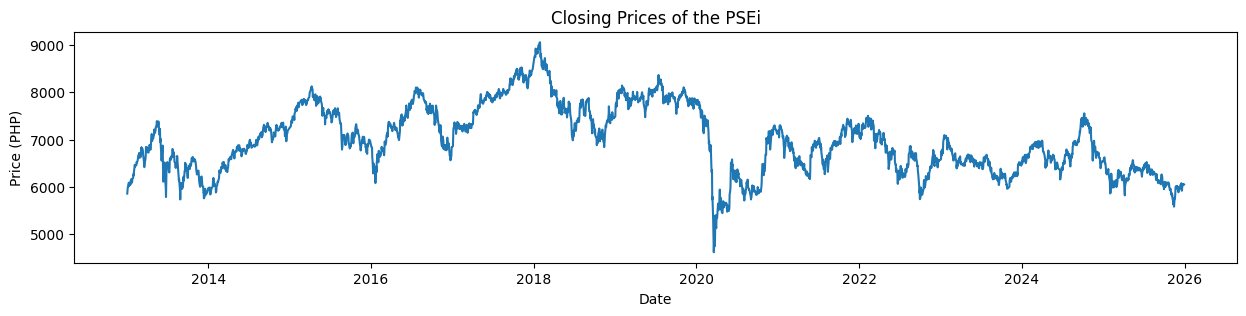

In [5]:
# plot the closing prices of the PSEi
plt.figure(figsize=(15, 3))
plt.plot(pse_data)
plt.xlabel('Date')
plt.ylabel('Price (PHP)')
plt.title('Closing Prices of the PSEi')
plt.show()

The data does not look stationary.

ADF Result: Stationary
KPSS Result: Stationary


C:\Users\Donna\AppData\Local\Temp\ipykernel_8976\325655696.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(log_returns)[1]


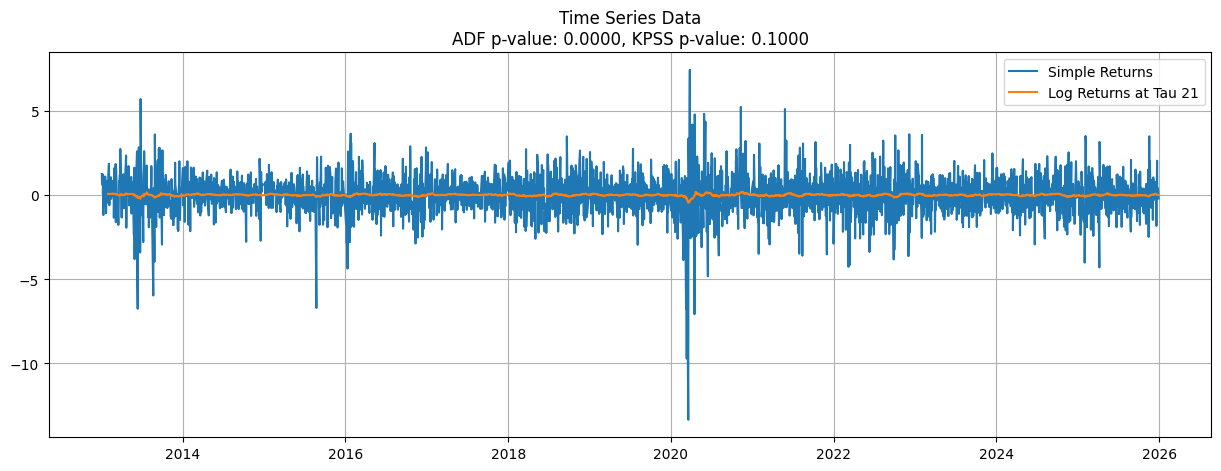

In [23]:
# get log returns
tau_val = 21
log_returns = np.log(pse_data['PSEI.PS']).diff(tau_val).dropna()
simple_returns = 100 * pse_data.pct_change().dropna()
pse_data_volatility = log_returns.rolling(window=2).std()

# checking for stationarity
p_value = 0.05
adf_res = adfuller(log_returns)[1]
kpss_res = kpss(log_returns)[1]

print("ADF Result:", "Stationary" if adf_res < p_value else "Not Stationary")
print("KPSS Result:", "Stationary" if kpss_res > p_value else "Not Stationary")

# plotting
plt.figure(figsize=(15, 5))
plt.plot(simple_returns, label='Simple Returns')
plt.plot(log_returns, label=f'Log Returns at Tau {tau_val}')
plt.title(f"Time Series Data\nADF p-value: {adf_res:.4f}, KPSS p-value: {kpss_res:.4f}")
plt.grid(True)
plt.legend()
plt.show()

## Train, val, test

In [24]:
# train test split with lookback
def train_test_split(data: pd.Series, lookback: int = 12, test_size: int = 12) -> Tuple[pd.Series, pd.Series]:
    """Create a train-test split on your pd.Series data.

    Parameters:
    -----------
    data (pd.Series): The univariate time series provided
    lookback (int): The lookback periods to consider
    test_size (int): The length of the test set

    Returns:
    --------
    Tuple (pd.Series): The (train, test) pandas series generated
    """
    
    split = data.shape[0] - test_size
    return (
        data.iloc[:split],
        data.iloc[split - lookback: ]
    )

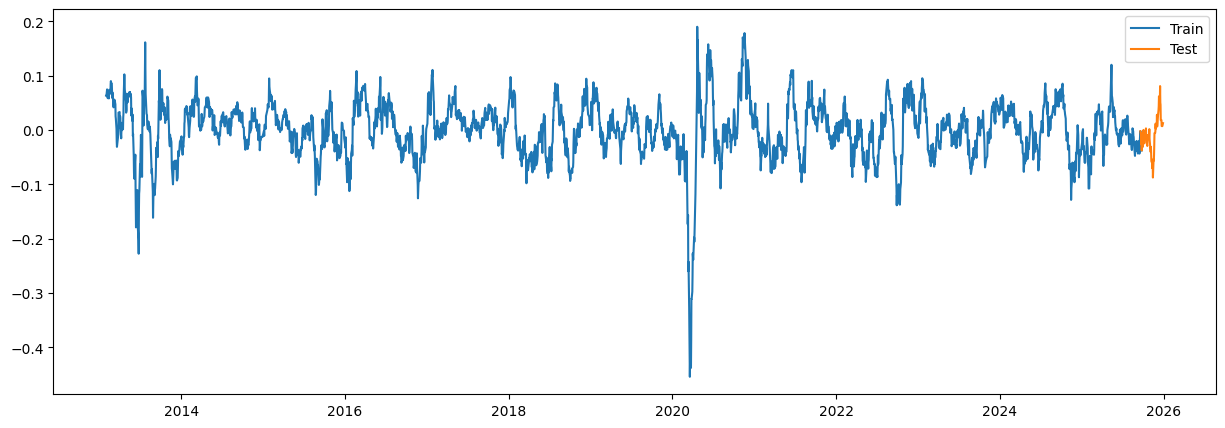

In [42]:
# determine number of points
test_percent = 0.2
test_size = int(np.floor(len(log_returns) * test_percent))
test_size = 63

# splitting
train, test = train_test_split(
    log_returns, 5, test_size
)

# plotting
plt.figure(figsize=(15, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend()
plt.show()

## Defining p, d, q

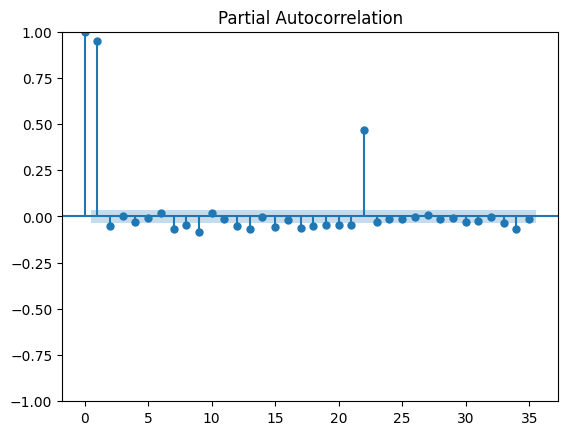

In [43]:
pacf_res = plot_pacf(train)

Based on the PACF plot, the best value for p is 1.

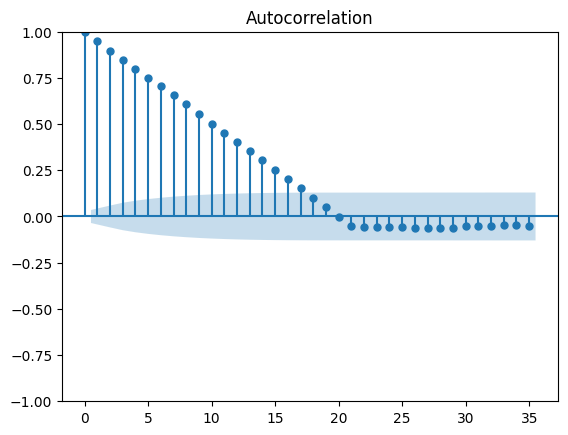

In [44]:
acf_res = plot_acf(train)

Based on the ACF plot, the best value for p is 17.

## GARCH Model

Since I couldn't find good lags for the ACF and PACF, then I opted to use GARCH(1,1).

In [45]:
# creating the model
model = arch_model(train, p=1, q=17)
model_fit = model.fit()

Iteration:      1,   Func. Count:     22,   Neg. LLF: 3.5801227174489862e+19
Iteration:      2,   Func. Count:     51,   Neg. LLF: 1.9275467918275264e+16
Iteration:      3,   Func. Count:     78,   Neg. LLF: 31405133.39806713
Iteration:      4,   Func. Count:    108,   Neg. LLF: 134806138.34450537
Iteration:      5,   Func. Count:    138,   Neg. LLF: 413687473981618.3
Iteration:      6,   Func. Count:    164,   Neg. LLF: 7.063470329965597e+16
Iteration:      7,   Func. Count:    191,   Neg. LLF: 17492479.0871063
Iteration:      8,   Func. Count:    220,   Neg. LLF: 3127739102543081.5
Iteration:      9,   Func. Count:    247,   Neg. LLF: 6678897.948367061
Iteration:     10,   Func. Count:    275,   Neg. LLF: -5493.8060518679795
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5493.806094650714
            Iterations: 14
            Function evaluations: 275
            Gradient evaluations: 10


C:\Users\Donna\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002755. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [46]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                PSEI.PS   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5493.81
Distribution:                  Normal   AIC:                          -10947.6
Method:            Maximum Likelihood   BIC:                          -10827.0
                                        No. Observations:                 3081
Date:                Tue, Jan 13 2026   Df Residuals:                     3080
Time:                        15:29:31   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.7383e-03  8.420e-04      4.440  9.007e-06 [2.088e-03,5.389e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.5096e-05  4.737e-05      1.163      0.245 [-3.775e-05,1.479e-04]
alpha[1]       0.2000  1.986e-02     10.070  7.480e-24      [  0.161,  0.239]
beta[1]        0.0459      3.074  1.493e-02      0.988      [ -5.978,  6.070]
beta[2]        0.0459      4.937  9.294e-03      0.993      [ -9.630,  9.721]
beta[3]        0.0459      0.807  5.685e-02      0.955      [ -1.536,  1.628]
beta[4]        0.0459      2.964  1.548e-02      0.988      [ -5.763,  5.855]
beta[5]        0.0459      4.892  9.379e-03      0.993      [ -9.542,  9.634]
beta[6]        0.0459      2.340  1.961e-02      0.984      [ -4.540,  4.631]
beta[7]        0.0459      0.404      0.114      0.910      [ -0.746,  0.838]
beta[8]        0.0459      2.008  2.285e-02      0.982      [ -3.890,  3.982]
beta[9]        0.0459      4.079  1.125e-02      0.991      [ -7.949,  8.040]
beta[10]       0.0459      1.849  2.481e-02      0.980      [ -3.579,  3.671]
beta[11]       0.0459      2.406  1.907e-02      0.985      [ -4.670,  4.762]
beta[12]       0.0459      6.269  7.319e-03      0.994      [-12.240, 12.332]
beta[13]       0.0459      1.677  2.736e-02      0.978      [ -3.241,  3.333]
beta[14]       0.0459      5.420  8.465e-03      0.993      [-10.577, 10.669]
beta[15]       0.0459      5.617  8.169e-03      0.993      [-10.963, 11.055]
beta[16]       0.0459      0.536  8.563e-02      0.932      [ -1.004,  1.096]
beta[17]       0.0459      2.065  2.221e-02      0.982      [ -4.002,  4.094]
=============================================================================

Covariance estimator: robust
"""

In [47]:
# getting predictions
predictions = model_fit.forecast(horizon = test_size)
preds = predictions.variance.values[-1, :]
preds = pd.Series(preds, index=log_returns[-test_size:].index)

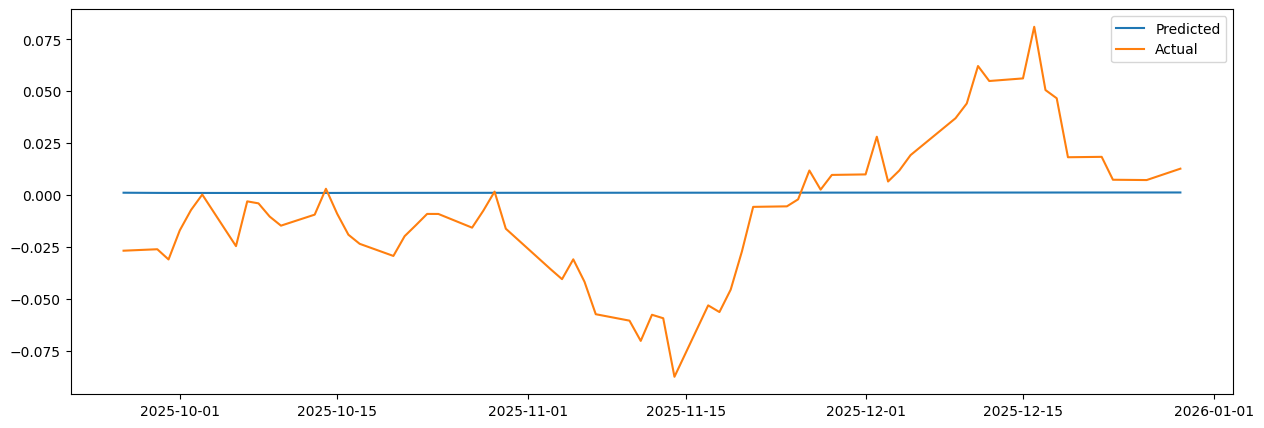

In [48]:
# plotting
plt.figure(figsize=(15, 5))
plt.plot(preds, label='Predicted')
plt.plot(log_returns[-test_size:], label='Actual')
plt.legend()
plt.show()

## Findings

1. Increasing the lag also allows for the ACF and PACF plots to pick up more signal.